# Iowa House Price prediction - Advanced Regression Techniques

In [105]:
# importing the necessary modules

import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

plt.style.use('seaborn')
warnings.filterwarnings("ignore")
pd.options.display.max_seq_items = 2000
pd.set_option('display.max_columns', 10000)


from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNet

In [68]:
def create_submission(predictions, id_col):
    '''
    This function creates the submission.csv file
    with the following headers:
    'Id' and 'SalePrice'
    '''
    actual_predictions = [math.exp(x) for x in predictions]
    helper_dict = {'Id':id_col,'SalePrice':actual_predictions}
    final_csv = pd.DataFrame(helper_dict)
    final_csv.to_csv('submission.csv',index=False)

In [69]:
# reading the training dataset
data = pd.read_csv('data/train.csv')

### Exploring the data

In [70]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Percentage of the values missing :

In [72]:
null_details = dict(data.isnull().sum().sort_values(ascending=False))
for items in null_details:
    null_details[items] = (null_details[items] / len(data)) * 100
null_details

{'PoolQC': 99.52054794520548,
 'MiscFeature': 96.30136986301369,
 'Alley': 93.76712328767123,
 'Fence': 80.75342465753424,
 'FireplaceQu': 47.26027397260274,
 'LotFrontage': 17.73972602739726,
 'GarageCond': 5.5479452054794525,
 'GarageType': 5.5479452054794525,
 'GarageYrBlt': 5.5479452054794525,
 'GarageFinish': 5.5479452054794525,
 'GarageQual': 5.5479452054794525,
 'BsmtExposure': 2.6027397260273974,
 'BsmtFinType2': 2.6027397260273974,
 'BsmtFinType1': 2.5342465753424657,
 'BsmtCond': 2.5342465753424657,
 'BsmtQual': 2.5342465753424657,
 'MasVnrArea': 0.547945205479452,
 'MasVnrType': 0.547945205479452,
 'Electrical': 0.0684931506849315,
 'Utilities': 0.0,
 'YearRemodAdd': 0.0,
 'MSSubClass': 0.0,
 'Foundation': 0.0,
 'ExterCond': 0.0,
 'ExterQual': 0.0,
 'Exterior2nd': 0.0,
 'Exterior1st': 0.0,
 'RoofMatl': 0.0,
 'RoofStyle': 0.0,
 'YearBuilt': 0.0,
 'LotConfig': 0.0,
 'OverallCond': 0.0,
 'OverallQual': 0.0,
 'HouseStyle': 0.0,
 'BldgType': 0.0,
 'Condition2': 0.0,
 'BsmtFinSF1'

### Data Overview

In [73]:
print ("Rows     : " ,data.shape[0])
print ("Columns  : " ,data.shape[1])
print ("\nFeatures : \n" ,data.columns.tolist())
print ("\nMissing values :  ", data.isnull().sum().values.sum())
print ("\nUnique values :  \n",data.nunique())

Rows     :  1460
Columns  :  81

Features : 
 ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3

In [74]:
# Getting the number of unique elements for each columns
data_dist = pd.DataFrame(data.nunique())

data_dist.columns = ['unique_terms']
data_dist.reset_index(inplace = True)
data_dist.rename(columns = {'index':'column'}, inplace = True)
data_dist

,column,unique_terms
0,Id,1460
1,MSSubClass,15
2,MSZoning,5
3,LotFrontage,110
4,LotArea,1073
5,Street,2
6,Alley,2
7,LotShape,4
8,LandContour,4
9,Utilities,2


#### Dividing categorical and the continuous variables

In [75]:
continuous_column = []
categorical_column = []

for index, row in data_dist.iterrows():
    if (row['unique_terms']) <= 16:
        categorical_column.append(data_dist['column'].iloc[index])
    else:
        continuous_column.append(data_dist['column'].iloc[index])

#### Dropping the ID column

In [76]:
data.drop(columns='Id', inplace=True)

In [77]:
cat_col = pd.DataFrame([len(categorical_column),len(continuous_column)],columns=['count'])
cat_col['type_of_variable'] = ['categorical','continuous']
fig = px.bar(cat_col,x='type_of_variable', y='count')
fig.show()

In [78]:
categorical = data.select_dtypes(include='object')
len(categorical.columns)

43

### The number of categorical features are way more than the continuous variables

##### Looking at the PoolQC variable.

In [79]:
data[data['PoolQC'].isna()==False]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036,LwQ,184,140,1360,GasA,Gd,Y,SBrkr,1360,1360,392,3112,1,1,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2,795,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000
810,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663,LwQ,377,0,1040,GasA,Fa,Y,SBrkr,1309,0,0,1309,1,0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2,484,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal,181000
1170,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,522,Unf,0,574,1096,GasA,TA,Y,SBrkr,1118,0,0,1118,1,0,1,0,3,1,TA,6,Typ,1,Po,Attchd,1977.0,Fin,1,358,TA,TA,Y,203,0,0,0,0,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal,171000
1182,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1386,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,RRAn,Norm,1Fam,2Story,7,5,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,184.0,TA,TA,CBlock,Gd,TA,No,BLQ,790,LwQ,469,133,1392,GasA,TA,Y,SBrkr,1392,1392,0,2784,1,0,3,1,5,1,Gd,12,Typ,2,TA,Attchd,1978.0,RFn,2,564,TA,TA,Y,0,112,0,0,440,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000
1423,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,7,1966,1966,Flat,Tar&Grv,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Av,Unf,0,Unf,0,697,697,GasA,TA,Y,SBrkr,1575,626,0,2201,0,0,2,0,4,1,Gd,8,Typ,1,Gd,Attchd,1966.0,Unf,2,432,Gd,Gd,Y,586,236,0,0,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970


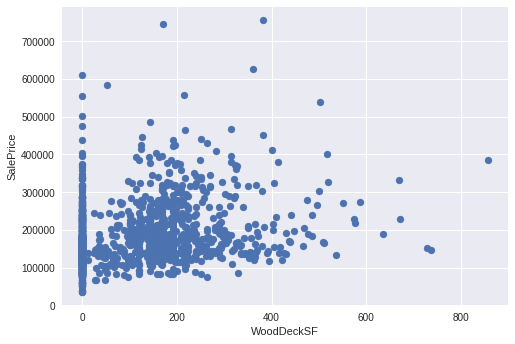

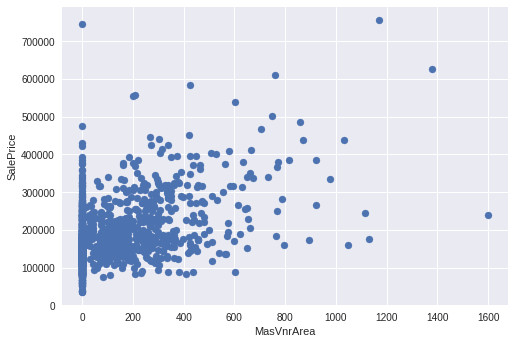

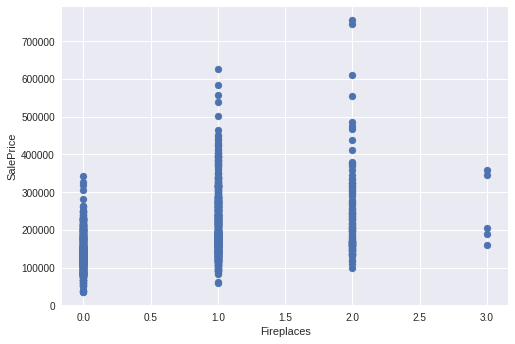

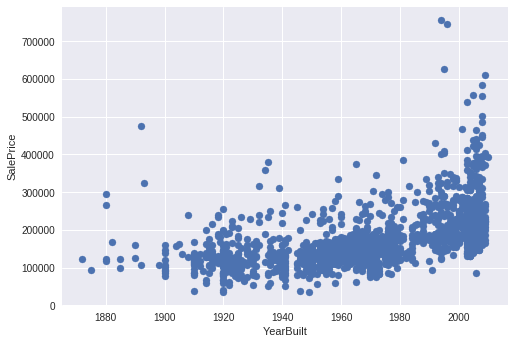

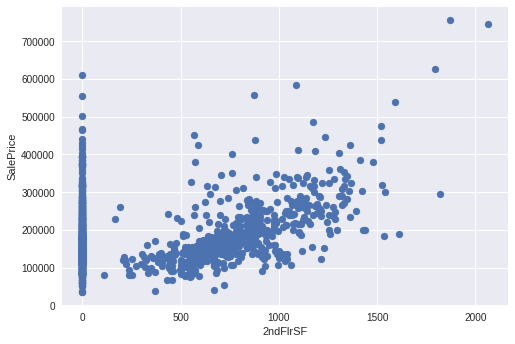

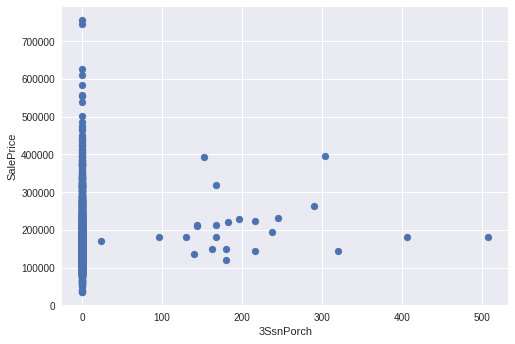

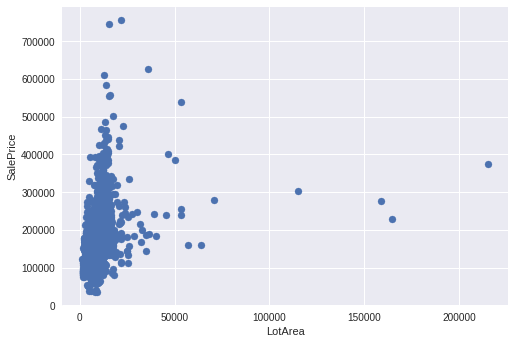

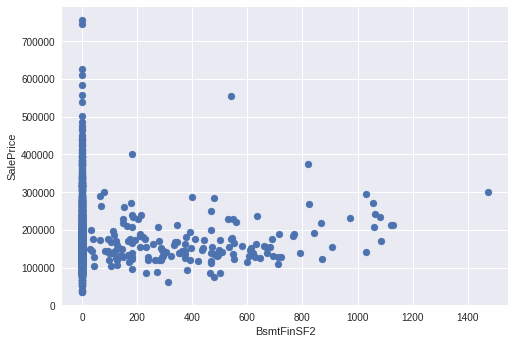

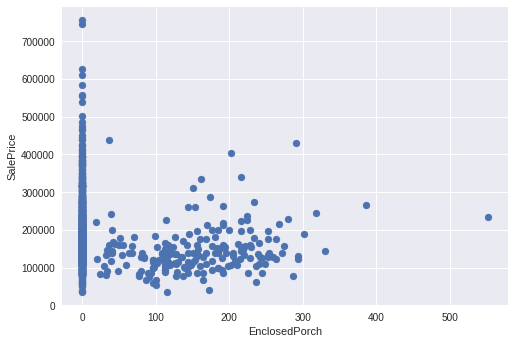

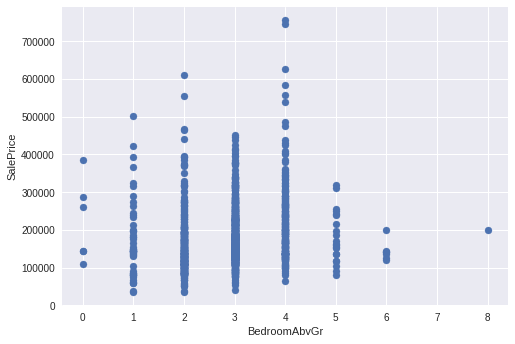

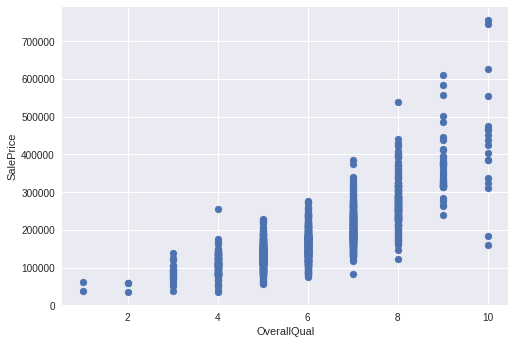

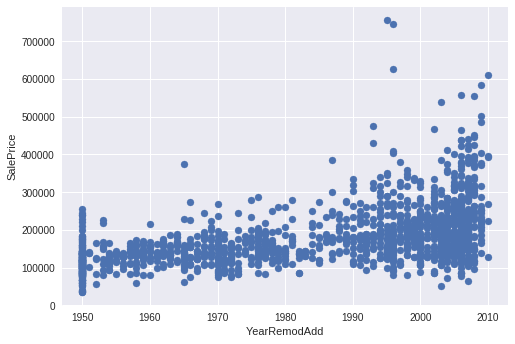

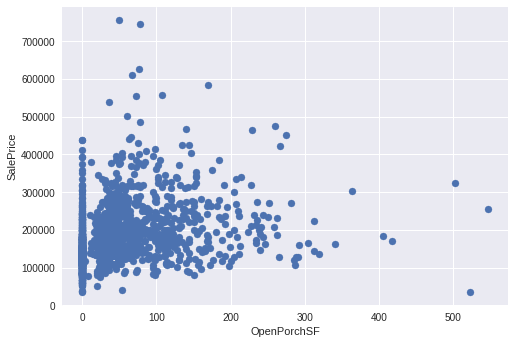

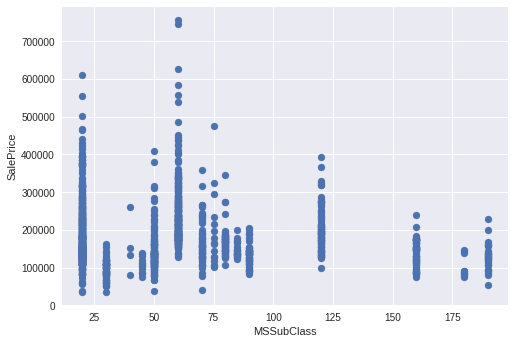

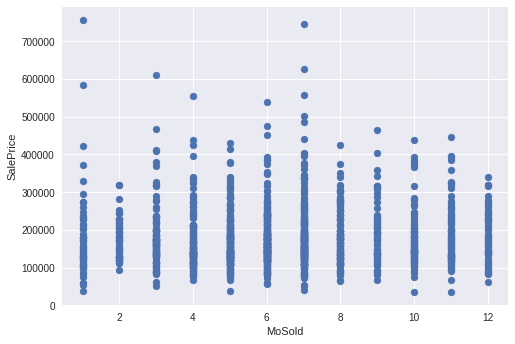

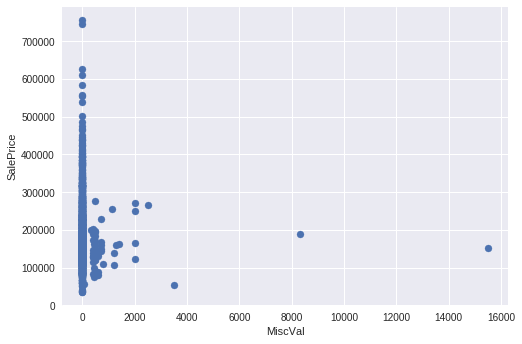

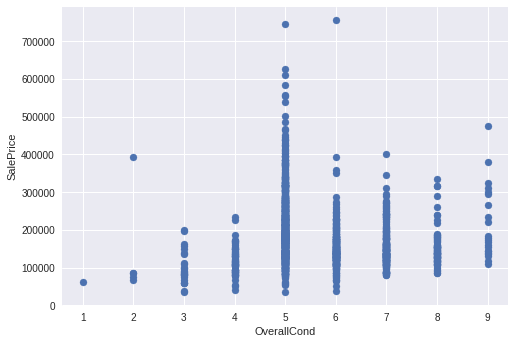

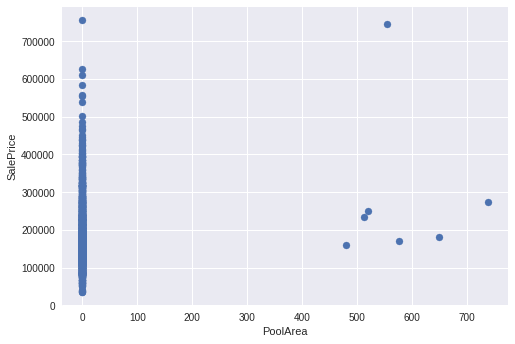

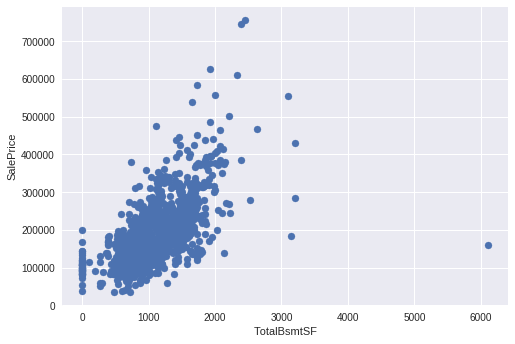

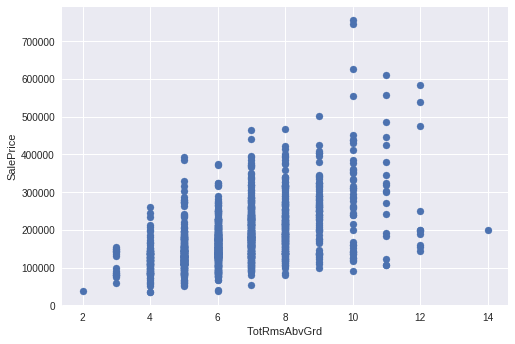

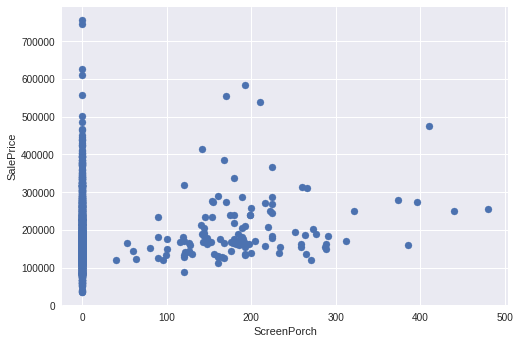

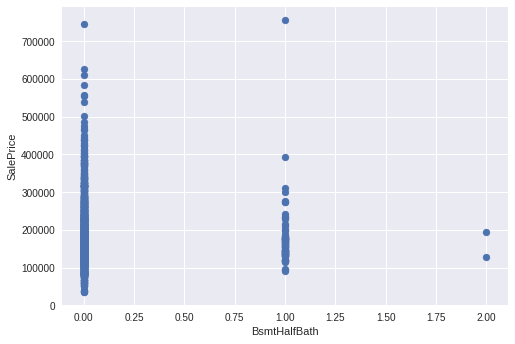

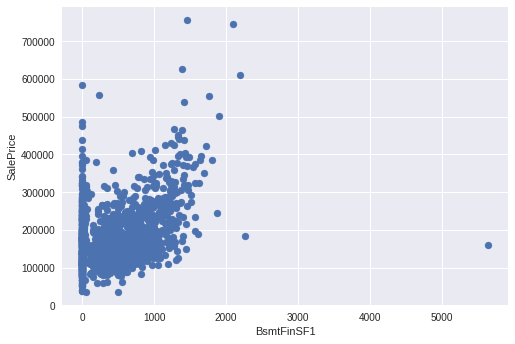

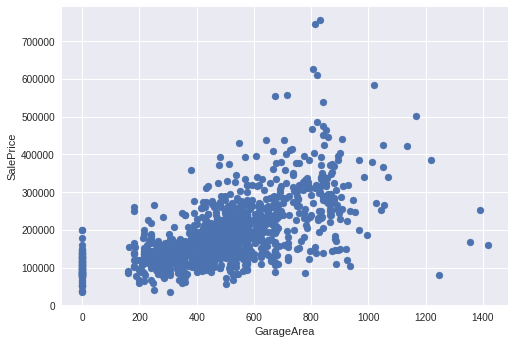

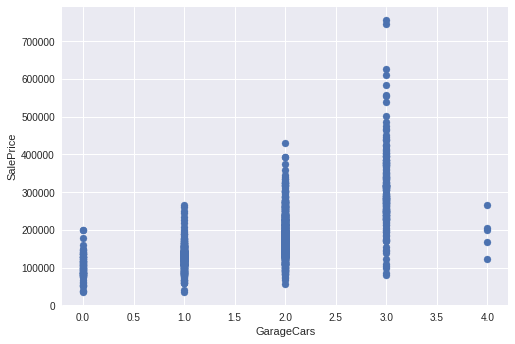

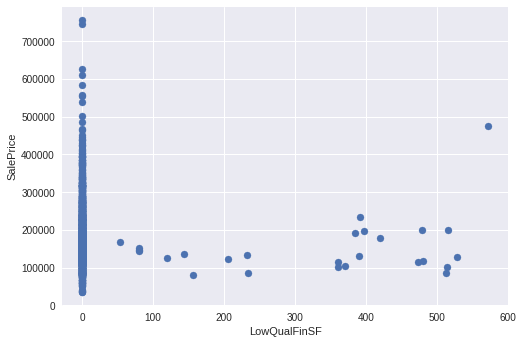

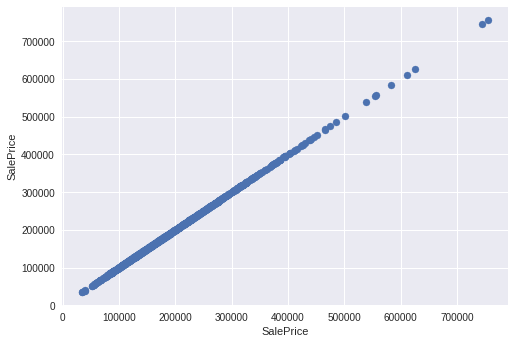

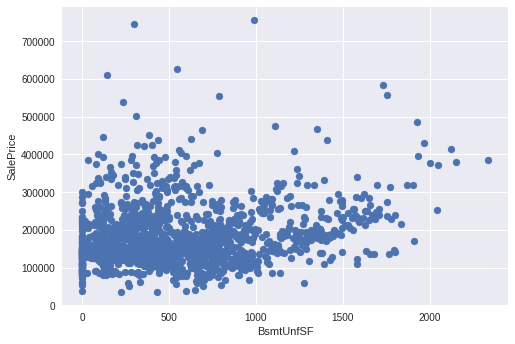

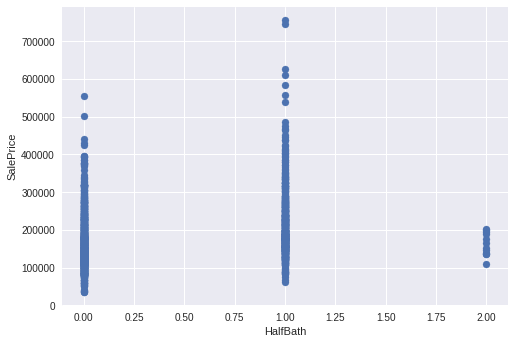

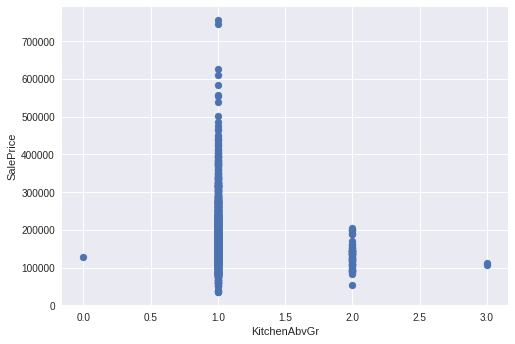

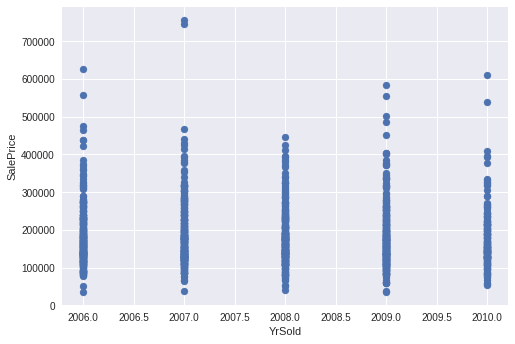

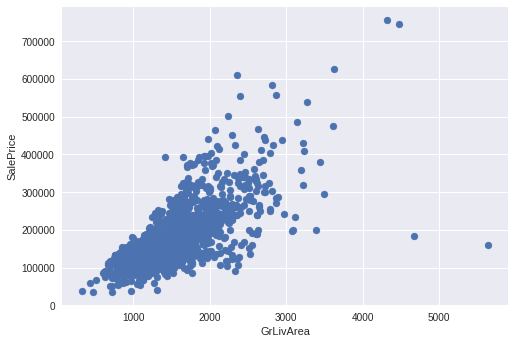

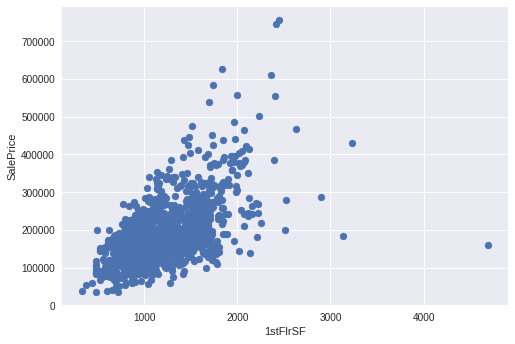

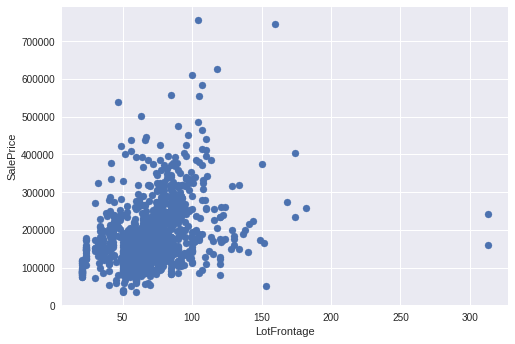

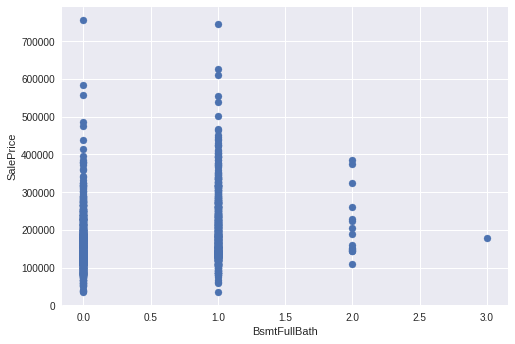

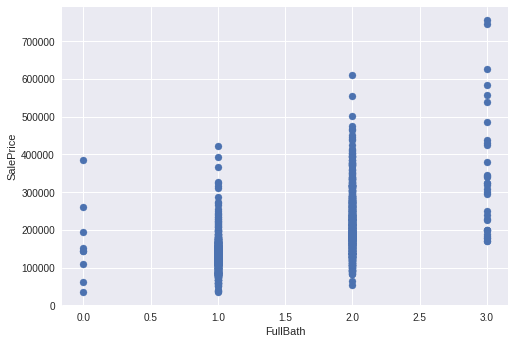

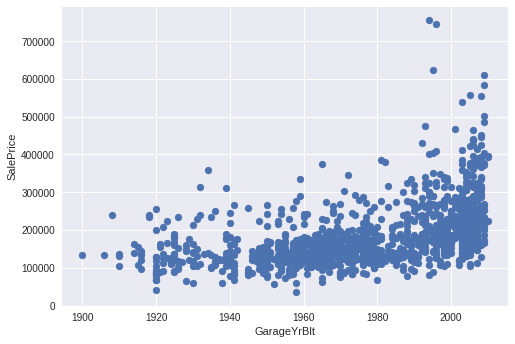

In [80]:
for each in (set(data.columns)-set(categorical.columns)):
    plt.scatter(data[each],data['SalePrice'])
    plt.xlabel(each)
    plt.ylabel('SalePrice')
    plt.show()

In [81]:
data.corrwith(data['SalePrice'])

MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
dtype: float64

In [82]:
data.corr()['SalePrice']

MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePrice, dtype: float64

#### Filling with NaN values in the column with the 'Other' data and removing the columns with high p values

In [83]:
cols_to_be_removed = ['MiscFeature', 'Alley', 'PoolQC', 'Electrical',
                      'MasVnrType','GarageQual', 'BsmtCond','BsmtQual',
                      'BsmtExposure','RoofMatl','Condition2']
data.drop(columns=cols_to_be_removed, inplace = True)

cat_ft =['Fence','FireplaceQu','GarageCond','GarageType',
         'GarageFinish','BsmtFinType2',
         'BsmtFinType1']

for ft in cat_ft:
    data[ft].fillna('Other',inplace=True)
    
    data['GarageYrBlt'].fillna(0,inplace=True)
data['MasVnrArea'].fillna(0,inplace=True)
data['LotFrontage']= data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#### Rechecking if we have any other missing values present

In [84]:
data.isna().sum().sort_values(ascending=False)

SalePrice       0
Foundation      0
RoofStyle       0
Exterior1st     0
Exterior2nd     0
               ..
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
MSSubClass      0
Length: 69, dtype: int64

In [85]:
object_features = data.select_dtypes(include='object').columns
object_features

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageCond', 'PavedDrive', 'Fence',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [86]:
def dummies(data):
    dummies_df = pd.DataFrame()
    object_features= data.select_dtypes(include='object').columns
    for name in object_features:
        dummies = pd.get_dummies(data[name],drop_first=False)
        dummies =dummies.add_prefix("{}_".format(name))
        dummies_df=pd.concat([dummies_df,dummies],axis=1)
    return dummies_df

data_dummy = dummies(data)
print(data_dummy.columns)
print(data_dummy.shape)

Index(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Saw

In [87]:
data=data.drop(columns = object_features, axis = 1)
print(data.columns)

final_data = pd.concat([data,data_dummy],axis = 1)
final_data.shape

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


(1460, 245)

In [88]:
final_data.isna().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 245, dtype: int64

#### Test/Train Split

In [89]:
train_data = final_data.iloc[:1400,:]
#val_data = final_data.iloc[1000:1450,:]
test_data = final_data.iloc[1400:,:]

print(train_data.shape)
#print(val_data.shape)
print(test_data.shape)

# Splitting into X and y for training purpose
X = train_data[train_data.columns.difference(['SalePrice'])]
print(len(X.columns))
y = np.log(train_data.loc[:,'SalePrice'])

# Splitting into X_test and y_test for testing purpose
X_test = test_data[test_data.columns.difference(['SalePrice'])]
y_test = np.log(test_data.loc[:,'SalePrice'])

(1400, 245)
(60, 245)
244


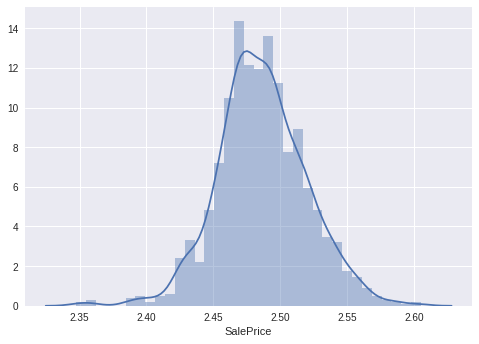

In [90]:
sns.distplot(np.log(y))

#### Fitting a standard OLS method

In [91]:
import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X_test) # make the predictions by the model
p_value_dict = dict(model.pvalues)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     70.42
Date:                Sat, 07 Sep 2019   Prob (F-statistic):               0.00
Time:                        21:01:04   Log-Likelihood:                 1100.9
No. Observations:                1400   AIC:                            -1786.
Df Residuals:                    1192   BIC:                            -694.9
Df Model:                         207                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
1stFlrSF               5.503e-05   3.21e-05      1.713      0.087   -7.99e-06       0.000
2ndFlrSF               2.438e-05   2.81e-05      0.868      0.386   -3.07e-05    7.95e-05
3SsnPorch                 0.0002      0.000      1.704      0.089   -3.14e-05       0.000
BedroomAbvGr              0.0075      0.007      1.044      0.297      -0.007       0.022
BldgType_1Fam             0.4241      0.166      2.555      0.011       0.098       0.750
BldgType_2fmCon           0.4937      0.166      2.980      0.003       0.169       0.819
BldgType_Duplex           0.4519      0.164      2.758      0.006       0.130       0.773
BldgType_Twnhs            0.3551      0.165      2.148      0.032       0.031       0.679
BldgType_TwnhsE           0.3899      0.164      2.371      0.018       0.067       0.713
BsmtFinSF1            -1.163e-05   1.48e-05     -0.788      0.431   -4.06e-05    1.73e-05
BsmtFinSF2              4.05e-05   3.23e-05      1.254      0.210   -2.28e-05       0.000
BsmtFinType1_ALQ          0.3284      0.118      2.790      0.005       0.097       0.559
BsmtFinType1_BLQ          0.3214      0.118      2.713      0.007       0.089       0.554
BsmtFinType1_GLQ          0.3339      0.119      2.811      0.005       0.101       0.567
BsmtFinType1_LwQ          0.2917      0.119      2.462      0.014       0.059       0.524
BsmtFinType1_Other        0.2409      0.169      1.423      0.155      -0.091       0.573
BsmtFinType1_Rec          0.3162      0.118      2.680      0.007       0.085       0.548
BsmtFinType1_Unf          0.2821      0.118      2.385      0.017       0.050       0.514
BsmtFinType2_ALQ          0.3366      0.120      2.795      0.005       0.100       0.573
BsmtFinType2_BLQ          0.2602      0.120      2.176      0.030       0.026       0.495
BsmtFinType2_GLQ          0.3212      0.122      2.628      0.009       0.081       0.561
BsmtFinType2_LwQ          0.2963      0.118      2.505      0.012       0.064       0.528
BsmtFinType2_Other        0.2945      0.160      1.836      0.067      -0.020       0.609
BsmtFinType2_Rec          0.2872      0.119      2.424      0.016       0.055       0.520
BsmtFinType2_Unf          0.3187      0.119      2.680      0.007       0.085       0.552
BsmtFullBath              0.0467      0.010      4.467      0.000       0.026       0.067
BsmtHalfBath              0.0180      0.016      1.133      0.257      -0.013       0.049
BsmtUnfSF             -1.449e-05   1.47e-05     -0.984      0.325   -4.34e-05    1.44e-05
CentralAir_N              1.0284      0.406      2.533      0.011       0.232       1.825
CentralAir_Y              1.0863      0.406      2.676      0.008       0.290       1.883
Condition1_Artery         0.2063      0.094      2.205      0.028       0.023       0.390
Condition1_Feedr       

In [92]:
confidence_interval_99_features = []
confidence_interval_95_features = []
confidence_interval_90_features = []

for item in p_value_dict:
    if p_value_dict[item] < 0.01:
        confidence_interval_99_features.append(item)

for item in p_value_dict:
    if p_value_dict[item] < 0.05:
        confidence_interval_95_features.append(item)
        
for item in p_value_dict:
    if p_value_dict[item] < 0.10:
        confidence_interval_95_features.append(item)
        

# Splitting into X and y for training purpose
X = train_data[confidence_interval_99_features]
y = np.log(train_data.loc[:,'SalePrice'])

# Splitting into X_test and y_test for testing purpose
X_test = test_data[confidence_interval_99_features]
y_test = np.log(test_data.loc[:,'SalePrice'])

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X_test) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.166e+05
Date:                Sat, 07 Sep 2019   Prob (F-statistic):                        0.00
Time:                        21:01:04   Log-Likelihood:                          916.93
No. Observations:                1400   AIC:                                     -1630.
Df Residuals:                    1298   BIC:                                     -1095.
Df Model:                         102                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
BldgType_2fmCon          -0.0369      0.027     -1.363      0.173      -0.090       0.016
BldgType_Duplex          -0.0408      0.023     -1.740      0.082      -0.087       0.005
BsmtFinType1_ALQ          0.0436      0.013      3.324      0.001       0.018       0.069
BsmtFinType1_BLQ          0.0502      0.014      3.506      0.000       0.022       0.078
BsmtFinType1_GLQ          0.0380      0.012      3.093      0.002       0.014       0.062
BsmtFinType1_Rec          0.0455      0.015      3.135      0.002       0.017       0.074
BsmtFinType2_ALQ          0.0925      0.033      2.795      0.005       0.028       0.157
BsmtFinType2_GLQ          0.0479      0.039      1.220      0.223      -0.029       0.125
BsmtFinType2_Unf          0.0350      0.012      2.903      0.004       0.011       0.059
BsmtFullBath              0.0494      0.009      5.398      0.000       0.031       0.067
CentralAir_Y              0.0417      0.020      2.126      0.034       0.003       0.080
Condition1_Norm           0.0549      0.012      4.627      0.000       0.032       0.078
Condition1_RRAn           0.0474      0.030      1.588      0.112      -0.011       0.106
Condition1_RRNn           0.0924      0.065      1.419      0.156      -0.035       0.220
ExterCond_Ex              0.0803      0.079      1.015      0.310      -0.075       0.235
ExterCond_TA              0.0154      0.012      1.312      0.190      -0.008       0.038
ExterQual_Fa              0.1073      0.045      2.383      0.017       0.019       0.196
ExterQual_TA              0.0214      0.012      1.726      0.085      -0.003       0.046
Exterior1st_BrkFace       0.1297      0.021      6.293      0.000       0.089       0.170
Exterior1st_MetalSd       0.0407      0.011      3.607      0.000       0.019       0.063
Exterior1st_Plywood       0.0311      0.016      1.990      0.047       0.000       0.062
Exterior1st_WdShing       0.0153      0.028      0.547      0.584      -0.040       0.070
Exterior2nd_ImStucc       0.0489      0.044      1.122      0.262      -0.037       0.134
Exterior2nd_Wd Sdng       0.0397      0.012      3.326      0.001       0.016       0.063
Fence_GdPrv               0.0249      0.025      0.988      0.323      -0.025       0.074
Fence_MnPrv               0.0303      0.020      1.484      0.138      -0.010       0.070
Fence_Other               0.0328      0.018      1.802      0.072      -0.003       0.069
FireplaceQu_Ex            0.0447      0.029      1.518      0.129      -0.013       0.102
FireplaceQu_Po            0.0496      0.031      1.617      0.106      -0.011       0.110
Foundation_CBlock         0.0073      0.014      0.504      0.614      -0.021       0.036
Foundation_PCo

In [93]:
np.sqrt(mean_squared_log_error(y_test, predictions))

0.012363079679082635

## Testing the first submission

In [101]:
data = pd.read_csv('data/test.csv')

continuous_column = []
categorical_column = []

for index, row in data_dist.iterrows():
    if (row['unique_terms']) <= 16:
        categorical_column.append(data_dist['column'].iloc[index])
    else:
        continuous_column.append(data_dist['column'].iloc[index])

id_col = data['Id']

# data.drop(columns='Id', inplace=True)

cols_to_be_removed = ['MiscFeature', 'Alley', 'PoolQC', 'Electrical',
                      'MasVnrType','GarageQual', 'BsmtCond','BsmtQual',
                      'BsmtExposure','RoofMatl','Condition2']

data.drop(columns=cols_to_be_removed, inplace = True)

cat_ft =['Fence','FireplaceQu','GarageCond','GarageType',
         'GarageFinish','BsmtFinType2',
         'BsmtFinType1']

for ft in cat_ft:
    data[ft].fillna('Other',inplace=True)


data['GarageYrBlt'].fillna(0,inplace=True)
data['MasVnrArea'].fillna(0,inplace=True)
data['LotFrontage']= data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

data_dummy = dummies(data)

data=data.drop(columns=object_features,axis=1)
actual_test_data = pd.concat([data,data_dummy],axis=1)

# Splitting into X_test and y_test for testing purpose
# X_test = actual_test_data[confidence_interval_99_features]

# predictions = model.predict(X_test) # make the predictions by the model

In [95]:
create_submission(predictions, id_col)

In [108]:
a = actual_test_data[actual_test_data['Id'] == 2122]
a.T

,661
Id,2122.0
MSSubClass,50.0
LotFrontage,52.0
LotArea,6240.0
OverallQual,4.0
OverallCond,7.0
YearBuilt,1929.0
YearRemodAdd,1950.0
MasVnrArea,0.0
BsmtFinSF1,80.0


#### Advanced techniques for tuning <br>
#### Will be tested at a later part of the project
#### The scores mentioned are the R-Square values

In [ ]:
# model_las_cv = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
# model_las_cv.fit(X, y)
predictions = model_las_cv.predict(X_test)
# X = train_data[confidence_interval_99_features]
# y = np.log(train_data.loc[:,'SalePrice'])

In [ ]:
#LassoCV
model_las_cv = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
k_fold = KFold(5)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    model_las_cv.fit(X.loc[train], y.loc[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, model_las_cv.alpha_, model_las_cv.score(X.loc[test], y.loc[test])))
    
# model_las_cv.score(X,y)

predictions = model_las_cv.predict(X_test)
# np.sqrt(mean_squared_log_error(y_test, predictions))

# X.columns[model_las_cv.coef_ <0]   # We can figure out which factors positively/negatively or do not affect the saleprice
# #RidgeCV
# model_ridge_cv = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
# k_fold = KFold(5)
# for k, (train, test) in enumerate(k_fold.split(X, y)):
#     model_ridge_cv.fit(X.loc[train], y.loc[train])
#     print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
#           format(k, model_ridge_cv.alpha_, model_ridge_cv.score(X.loc[test], y.loc[test])))
    
# model_ridge_cv.score(X,y)
# model_ridge_cv.score(X_test,y_test)
# predictions = model_ridge_cv.predict(X_test)
# np.sqrt(mean_squared_log_error( y_test, predictions ))
# model_en = ElasticNet(random_state=1, alpha=0.00065, max_iter=3000)
# model_en.fit(X, y)
# predictions = model_en.predict(X_test)
# np.sqrt(mean_squared_log_error(y_test, predictions))